### DCNN论文复现联系
#### 1.下载数据集

In [ ]:
!wget -N https://raw.githubusercontent.com/eebowen/Transfer-Learning-and-Deep-Neural-Network-Acceleration-for-Image-Classification/master/nntools.py
!wget -N https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!tar -zxvf BSDS300-images.tgz
dataset_root_dir = './BSDS300/images/'

--2022-02-10 13:16:57--  https://raw.githubusercontent.com/eebowen/Transfer-Learning-and-Deep-Neural-Network-Acceleration-for-Image-Classification/master/nntools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12781 (12K) [text/plain]
Saving to: ‘nntools.py’

nntools.py          100%[===================>]  12.48K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2022-02-10 13:16:58 (71.8 MB/s) - ‘nntools.py’ saved [12781/12781]

--2022-02-10 13:16:58--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, a

### 掉包

In [ ]:
%matplotlib inline

%matplotlib inline

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


### 2.训练集加噪
标准差为30的高斯噪声180*180彩铅（左上角或者随机位置）

In [ ]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')   
        # 随机裁剪
        #i = np.random.randint(clean.size[0] - self.image_size[0])
        #j = np.random.randint(clean.size[1] - self.image_size[1])
        i=0
        j=0
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # 转换张量
            tv.transforms.ToTensor(),
            # [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [ ]:
def myimshow(image,ax = plt):
  image = image.to('cpu').numpy()
  image = np.moveaxis(image,[0,1,2],[2,0,1])
  image = (image + 1) / 2
  image[image < 0] = 0
  image[image > 1] = 1
  h = ax.imshow(image)
  ax.axis('off')
  return h

导入训练集和测试集进入

In [ ]:
train_set= NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir,mode = 'test',image_size = (320,320))

image size is torch.Size([3, 320, 320]).


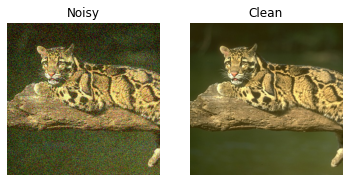

In [ ]:
x = test_set[0]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

### 3.DnCNN
loss使用的是MSELoss

In [ ]:
import nntools as nt
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

### CNN网络为什么要写一个权重
无权重初始化

In [ ]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

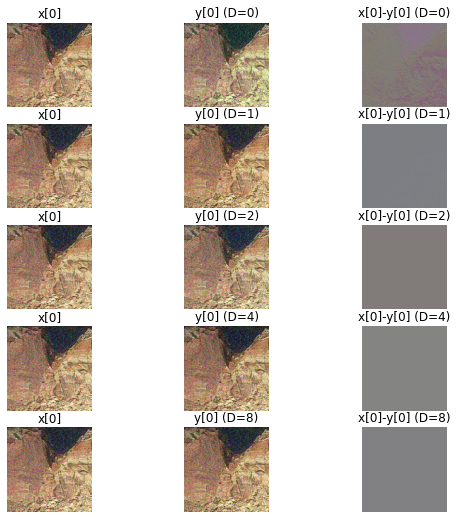

In [ ]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x) # 4-d
    # 3-d
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

D = 0才有残差输出，梯度消失，没法炼丹
带着权重跑一下

In [ ]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # Batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

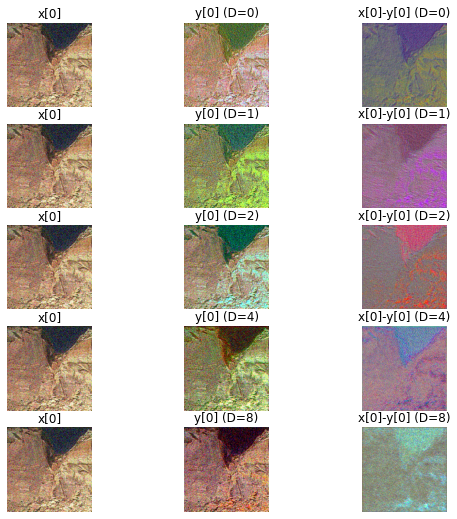

In [ ]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9,9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)
    
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

### 计算PSNR

In [ ]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [ ]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

DnCNN 炼丹

In [ ]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="./checkpoints/denoising1", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 (Time: 18.39s)
Epoch 2 (Time: 17.80s)
Epoch 3 (Time: 18.02s)
Epoch 4 (Time: 18.07s)
Epoch 5 (Time: 17.95s)
Epoch 6 (Time: 18.16s)
Epoch 7 (Time: 18.09s)
Epoch 8 (Time: 18.08s)
Epoch 9 (Time: 18.15s)
Epoch 10 (Time: 17.98s)
Epoch 11 (Time: 18.09s)
Epoch 12 (Time: 18.07s)
Epoch 13 (Time: 17.90s)
Epoch 14 (Time: 18.11s)
Epoch 15 (Time: 18.09s)
Epoch 16 (Time: 18.08s)
Epoch 17 (Time: 18.11s)
Epoch 18 (Time: 17.96s)
Epoch 19 (Time: 18.06s)
Epoch 20 (Time: 18.09s)
Epoch 21 (Time: 18.03s)
Epoch 22 (Time: 18.21s)
Epoch 23 (Time: 18.20s)
Epoch 24 (Time: 18.09s)
Epoch 25 (Time: 18.16s)
Epoch 26 (Time: 17.96s)
Epoch 27 (Time: 18.11s)
Epoch 28 (Time: 18.07s)
Epoch 29 (Time: 18.01s)
Epoch 30 (Time: 18.15s)
Epoch 31 (Time: 18.14s)
Epoch 32 (Time: 18.12s)
Epoch 33 (Time: 18.16s)
Epoch 34 (Time: 18.01s)
Epoch 35 (Time: 18.06s)
Epoch 36 (Time: 18.11s)
Epoch 37 (Time: 17.95s)
Epoch 38 (Time: 18.16s)
Epoch 39 (Time: 18.08s)
Epoch 40 (Time: 18.20s)
Epoch 41 (Ti

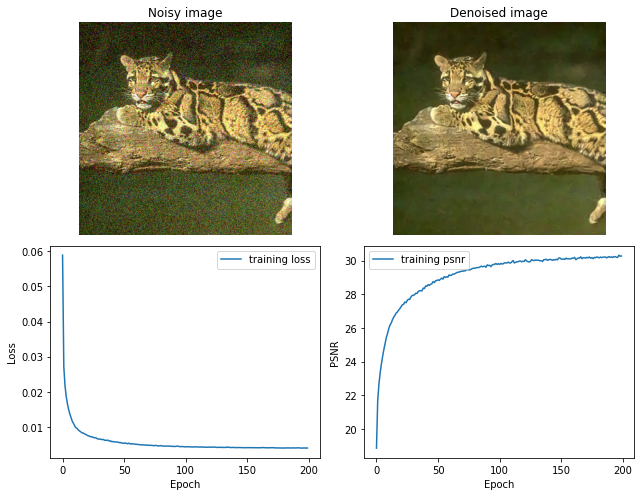

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[0][0]))

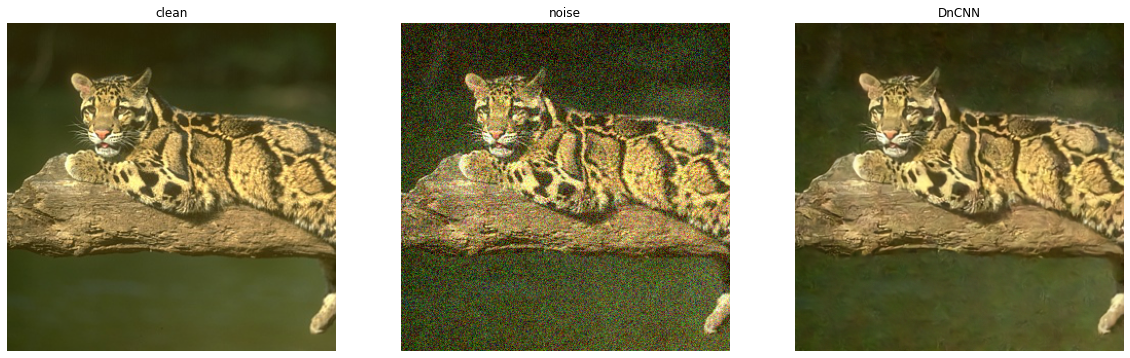

In [ ]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'DnCNN']

x, clean = test_set[0]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(20,10), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')